# Initialization

In [1]:
from __future__ import print_function


from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard,ReduceLROnPlateau
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
# import imgaug as ia
from tqdm import tqdm

# from imgaug import augmenters as iaa
import numpy as np
import pickle
import os, cv2
from preprocessing import parse_annotation, BatchGenerator
from utils import WeightReader, decode_netout, draw_boxes

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

%matplotlib inline

Using TensorFlow backend.


In [2]:
LABELS = ['obj']#['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

IMAGE_H, IMAGE_W = 224, 224#416, 416
GRID_H,  GRID_W  = 7, 7#13 , 13
BOX              = 10
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3#0.5
NMS_THRESHOLD    = 0.3#0.45

# coco dataset anchors
ANCHORS = [1.99,4.15, 3.78,5.13, 4.78,2.38, 5.99,3.60, 6.15,5.81]
NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 32
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 5#0

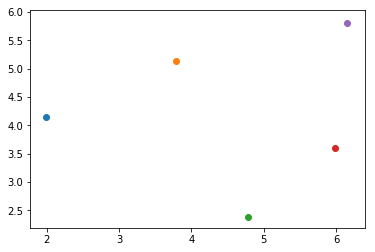

In [5]:
for i in range(int(len(ANCHORS)/2)):
    plt.scatter(ANCHORS[2*i], ANCHORS[2*i+1])

# Construct the network

In [6]:
from keras.models import Model
import tensorflow as tf
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU

import numpy as np
import os
import cv2
from utils import decode_netout, compute_overlap, compute_ap
from keras.applications.mobilenet import MobileNet
from keras.layers.merge import concatenate
from keras.optimizers import SGD, Adam, RMSprop
from preprocessing import BatchGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
# from backend import MobileNetFeature 

MOBILENET_BACKEND_PATH  = "mobile-net-yolo.h5"   # should be hosted on a server

class BaseFeatureExtractor(object):
    """docstring for ClassName"""

    # to be defined in each subclass
    def __init__(self, input_size):
        raise NotImplementedError("error message")

    # to be defined in each subclass
    def normalize(self, image):
        raise NotImplementedError("error message")       

    def get_output_shape(self):
        return self.feature_extractor.get_output_shape_at(-1)[1:3]

    def extract(self, input_image):
        return self.feature_extractor(input_image)

    
class MobileNetFeature(BaseFeatureExtractor):
    """docstring for ClassName"""
    def __init__(self, input_size):
        input_image = Input(shape=(input_size, input_size, 3))

        mobilenet = MobileNet(input_shape=(224,224,3), include_top=False, weights=None)
        mobilenet.load_weights(MOBILENET_BACKEND_PATH)

        x = mobilenet(input_image)

        self.feature_extractor = Model(input_image, x)  

    def normalize(self, image):
        image = image / 255.
        image = image - 0.5
        image = image * 2.

        return image
 

In [5]:
input_size = 224
max_box_per_image = TRUE_BOX_BUFFER # ANCHORS * BOX
nb_box = BOX
nb_class = CLASS


input_image     = Input(shape=(input_size, input_size, 3))
true_boxes = Input(shape=(1, 1, 1, max_box_per_image , 4))  

feature_extractor = MobileNetFeature(input_size)

# print(feature_extractor.get_output_shape())    
grid_h, grid_w = feature_extractor.get_output_shape()        
features = feature_extractor.extract(input_image)            

# make the object detection layer
output = Conv2D(nb_box * (4 + 1 + nb_class), 
                (1,1), strides=(1,1), 
                padding='same', 
                name='DetectionLayer', 
                kernel_initializer='lecun_normal')(features)
output = Reshape((grid_h, grid_w, nb_box, 4 + 1 + nb_class))(output)
output = Lambda(lambda args: args[0])([output, true_boxes])

model = Model([input_image, true_boxes], output)


# initialize the weights of the detection layer
layer = model.layers[-4]
weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(grid_h*grid_w)
new_bias   = np.random.normal(size=weights[1].shape)/(grid_h*grid_w)

layer.set_weights([new_kernel, new_bias])

# print a summary of the whole model
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 7, 7, 1024)   3228864     input_1[0][0]                    
__________________________________________________________________________________________________
DetectionLayer (Conv2D)         (None, 7, 7, 60)     61500       model_1[1][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 7, 7, 10, 6)  0           DetectionLayer[0][0]             
__________________________________________________________________________________________________
input_2 (I

In [6]:
model.input, model.output

([<tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>,
  <tf.Tensor 'input_2:0' shape=(?, 1, 1, 1, 5, 4) dtype=float32>],
 <tf.Tensor 'lambda_1/Identity:0' shape=(?, 7, 7, 10, 6) dtype=float32>)

# Perform training

**Loss function**

$$\begin{multline}
\lambda_\textbf{coord}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
     L_{ij}^{\text{obj}}
            \left[
            \left(
                x_i - \hat{x}_i
            \right)^2 +
            \left(
                y_i - \hat{y}_i
            \right)^2
            \right]
\\
+ \lambda_\textbf{coord} 
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
         L_{ij}^{\text{obj}}
         \left[
        \left(
            \sqrt{w_i} - \sqrt{\hat{w}_i}
        \right)^2 +
        \left(
            \sqrt{h_i} - \sqrt{\hat{h}_i}
        \right)^2
        \right]
\\
+ \sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
        L_{ij}^{\text{obj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ \lambda_\textrm{noobj}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
    L_{ij}^{\text{noobj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ \sum_{i = 0}^{S^2}
L_i^{\text{obj}}
    \sum_{c \in \textrm{classes}}
        \left(
            p_i(c) - \hat{p}_i(c)
        \right)^2
\end{multline}$$

In [7]:
def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, BOX, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
#     ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
#     ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
#     ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = 3*loss_xy + 3*loss_wh + loss_conf + 1.5*loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

    """
    Debugging code
    """    
#     current_recall = nb_pred_box/(nb_true_box + 1e-6)
#     total_recall = tf.assign_add(total_recall, current_recall) 

#     loss = tf.Print(loss1, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
#     loss = tf.Print(loss1, [loss_xy], message='Loss XY \t', summarize=1000)
#     loss = tf.Print(loss1, [loss_wh], message='Loss WH \t', summarize=1000)
#     loss = tf.Print(loss1, [loss_conf], message='Loss Conf \t', summarize=1000)
#     loss = tf.Print(loss1, [loss_class], message='Loss Class \t', summarize=1000)
#     loss = tf.Print(loss1, [loss], message='Total Loss \t', summarize=1000)
#     loss = tf.Print(loss1, [current_recall], message='Current Recall \t', summarize=1000)
#     loss = tf.Print(loss1, [total_recall/seen], message='Average Recall \t', summarize=1000)
    
    return loss

**Parse the annotations to construct train generator and validation generator**

In [4]:
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : TRUE_BOX_BUFFER,
}

In [9]:
def normalize(image):
    return image / 255.

In [2]:
import xml.etree.ElementTree as ET

def parse_annotation(ann_dir, img_dir, labels=[]):
    all_imgs = []
    seen_labels = {}
    
    for ann in sorted(os.listdir(ann_dir)):
        img = {'object':[]}

        tree = ET.parse(ann_dir + ann)
        
        for elem in tree.iter():
            if 'filename' in elem.tag:
                img['filename'] = img_dir + elem.text
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                
                for attr in list(elem):
                    if 'name' in attr.tag:
                        obj['name'] = attr.text

                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']] = 1
                        
                        if len(labels) > 0 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]
                            
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0:
            all_imgs += [img]
                        
    return all_imgs, seen_labels

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os


df = pd.read_csv('/home/ankish1/ankish_save/yolo/data/level3_data/training_set.csv')

train_dir = '/home/ankish1/ankish_save/yolo/data/train/images/'
train_data_prepare = []

for i in range(df.shape[0]):
    col = df.iloc[i]
    one_file = {}
    one_file['filename'] = train_dir + col['image_name']
    one_file['width'] = 640
    one_file['height'] = 480

    one_file['object'] = []
    inner_object = {}
    inner_object['name'] = 'obj'
    inner_object['xmin'] = col['x1']
    inner_object['ymin'] = col['y1']
    inner_object['xmax'] = col['x2']
    inner_object['ymax'] = col['y2']
    
    
    one_file['object'] = [inner_object]
    train_data_prepare.append(one_file)
    

In [4]:
train_data_prepare[:3]

[{'filename': '/home/ankish1/ankish_save/yolo/data/train/images/JPEG_20160517_140621_1000651031832.png',
  'width': 640,
  'height': 480,
  'object': [{'name': 'obj',
    'xmin': 78,
    'ymin': 83,
    'xmax': 446,
    'ymax': 422}]},
 {'filename': '/home/ankish1/ankish_save/yolo/data/train/images/1473231510890DeeplearnS11456.png',
  'width': 640,
  'height': 480,
  'object': [{'name': 'obj',
    'xmin': 73,
    'ymin': 146,
    'xmax': 567,
    'ymax': 351}]},
 {'filename': '/home/ankish1/ankish_save/yolo/data/train/images/1476881557883Untitled1.png',
  'width': 640,
  'height': 480,
  'object': [{'name': 'obj',
    'xmin': 13,
    'ymin': 124,
    'xmax': 561,
    'ymax': 362}]}]

In [5]:
import random
import argparse
import numpy as np

# from preprocessing import parse_annotation
import json

argparser = argparse.ArgumentParser()

argparser.add_argument(
    '-c',
    '--conf',
    default='config.json',
    help='path to configuration file')

argparser.add_argument(
    '-a',
    '--anchors',
    default=5,
    help='number of anchors to use')

def IOU(ann, centroids):
    w, h = ann
    similarities = []

    for centroid in centroids:
        c_w, c_h = centroid

        if c_w >= w and c_h >= h:
            similarity = w*h/(c_w*c_h)
        elif c_w >= w and c_h <= h:
            similarity = w*c_h/(w*h + (c_w-w)*c_h)
        elif c_w <= w and c_h >= h:
            similarity = c_w*h/(w*h + c_w*(c_h-h))
        else: #means both w,h are bigger than c_w and c_h respectively
            similarity = (c_w*c_h)/(w*h)
        similarities.append(similarity) # will become (k,) shape

    return np.array(similarities)

def avg_IOU(anns, centroids):
    n,d = anns.shape
    sum = 0.

    for i in range(anns.shape[0]):
        sum+= max(IOU(anns[i], centroids))

    return sum/n

def print_anchors(centroids):
    anchors = centroids.copy()

    widths = anchors[:, 0]
    sorted_indices = np.argsort(widths)

    r = "anchors: ["
    for i in sorted_indices[:-1]:
        r += '%0.2f,%0.2f, ' % (anchors[i,0], anchors[i,1])

    #there should not be comma after last anchor, that's why
    r += '%0.2f,%0.2f' % (anchors[sorted_indices[-1:],0], anchors[sorted_indices[-1:],1])
    r += "]"

    print(r)
    return r

def run_kmeans(ann_dims, anchor_num):
    ann_num = ann_dims.shape[0]
    iterations = 0
    prev_assignments = np.ones(ann_num)*(-1)
    iteration = 0
    old_distances = np.zeros((ann_num, anchor_num))

    indices = [random.randrange(ann_dims.shape[0]) for i in range(anchor_num)]
    centroids = ann_dims[indices]
    anchor_dim = ann_dims.shape[1]

    while True:
        distances = []
        iteration += 1
        for i in range(ann_num):
            d = 1 - IOU(ann_dims[i], centroids)
            distances.append(d)
        distances = np.array(distances) # distances.shape = (ann_num, anchor_num)

        print("iteration {}: dists = {}".format(iteration, np.sum(np.abs(old_distances-distances))))

        #assign samples to centroids
        assignments = np.argmin(distances,axis=1)

        if (assignments == prev_assignments).all() :
            return centroids

        #calculate new centroids
        centroid_sums=np.zeros((anchor_num, anchor_dim), np.float)
        for i in range(ann_num):
            centroid_sums[assignments[i]]+=ann_dims[i]
        for j in range(anchor_num):
            centroids[j] = centroid_sums[j]/(np.sum(assignments==j) + 1e-6)

        prev_assignments = assignments.copy()
        old_distances = distances.copy()
       


In [5]:

df = pd.read_csv('/home/ankish1/ankish_save/yolo/data/level3_data/training_set.csv')

train_dir = '/home/ankish1/ankish_save/yolo/data/train/images/'
train_data_prepare = []

for i in range(df.shape[0]):
    col = df.iloc[i]
    one_file = {}
    one_file['filename'] = train_dir + col['image_name']
    one_file['width'] = 640
    one_file['height'] = 480

    one_file['object'] = []
    inner_object = {}
    inner_object['name'] = 'obj'
    inner_object['xmin'] = col['x1']
    inner_object['ymin'] = col['y1']
    inner_object['xmax'] = col['x2']
    inner_object['ymax'] = col['y2']
    
    
    one_file['object'] = [inner_object]
    train_data_prepare.append(one_file)
    

NameError: name 'pd' is not defined

In [6]:
len(train_data_prepare)

24000

In [48]:
grid_w = 224.0/32
grid_h = 224.0/32

# run k_mean to find the anchors
annotation_dims = []
for image in train_data_prepare:
    cell_w = image['width']/grid_w
    cell_h = image['height']/grid_h
    
    for obj in image['object']:
        relative_w = (float(obj['xmax']) - float(obj['xmin']))/cell_w
        relatice_h = (float(obj["ymax"]) - float(obj['ymin']))/cell_h
        annotation_dims.append(tuple(map(float, (relative_w,relatice_h))))

#     break
annotation_dims = np.array(annotation_dims)

In [49]:
annotation_dims.shape

(24000, 2)

In [50]:
num_anchors = 5
centroids = run_kmeans(annotation_dims, num_anchors)

# write anchors to file
print('\naverage IOU for', num_anchors, 'anchors:', '%0.2f' % avg_IOU(annotation_dims, centroids))
print_anchors(centroids)

iteration 1: dists = 59418.75256568285
iteration 2: dists = 6657.820554175895
iteration 3: dists = 2452.9717882840355
iteration 4: dists = 1284.9135413119348
iteration 5: dists = 876.8556732061843
iteration 6: dists = 698.7946615443221
iteration 7: dists = 564.5009656411238
iteration 8: dists = 517.7002956674772
iteration 9: dists = 453.3051539638634
iteration 10: dists = 423.9918681940299
iteration 11: dists = 391.6375902020466
iteration 12: dists = 397.88478813539837
iteration 13: dists = 514.2469624599219
iteration 14: dists = 1083.9212850465394
iteration 15: dists = 1164.3211211395167
iteration 16: dists = 916.7289892877083
iteration 17: dists = 797.6237335584954
iteration 18: dists = 950.8833680969221
iteration 19: dists = 787.9593072735738
iteration 20: dists = 614.502995576621
iteration 21: dists = 403.5896550874954
iteration 22: dists = 240.9994543554747
iteration 23: dists = 148.582331010084
iteration 24: dists = 94.69891572213112
iteration 25: dists = 86.16503803594482
iterat

'anchors: [1.99,4.15, 3.78,5.13, 4.78,2.38, 5.99,3.60, 6.15,5.81]'

In [8]:
import os
os.listdir('../../raccoon-data')

['train-images', 'val-annotations', 'train-annotations', 'val-images']

In [9]:
os.listdir('../../')

['coco-data',
 'coco.names',
 'retinaNet',
 'flipkart',
 'flipkart.zip',
 'conditional-yolo',
 'test.csv',
 'test-yolo.zip',
 'tensorflow-yolo-v3',
 '.ipynb_checkpoints',
 'data']

In [10]:
os.listdir('../../coco-data/VOCdevkit/VOC2012/')

['ImageSets',
 'Annotations',
 '2007_000129.jpg',
 'explore dataset.ipynb',
 '2007_000123.jpg',
 'JPEGImages',
 'SegmentationClass',
 '2007_000061.png',
 '2007_000042.png',
 'SegmentationObject',
 '2007_000170.png',
 '2007_000175.png',
 '.ipynb_checkpoints',
 '2007_000129.png']

In [15]:
os.listdir('../../coco-data/VOCdevkit/VOC2012/SegmentationObject/')

['2010_003468.png',
 '2011_000338.png',
 '2009_005038.png',
 '2007_006761.png',
 '2010_004783.png',
 '2008_004026.png',
 '2009_003387.png',
 '2007_009841.png',
 '2008_003329.png',
 '2009_004213.png',
 '2007_001284.png',
 '2009_002856.png',
 '2011_002951.png',
 '2010_003781.png',
 '2009_002010.png',
 '2011_001133.png',
 '2008_001510.png',
 '2007_008140.png',
 '2010_004288.png',
 '2007_009889.png',
 '2007_000999.png',
 '2011_001875.png',
 '2007_005086.png',
 '2007_009348.png',
 '2009_003012.png',
 '2011_001794.png',
 '2009_001140.png',
 '2010_005505.png',
 '2007_009950.png',
 '2009_001937.png',
 '2009_000839.png',
 '2010_002047.png',
 '2008_001135.png',
 '2010_003758.png',
 '2010_002139.png',
 '2009_002164.png',
 '2011_001753.png',
 '2009_004217.png',
 '2010_004382.png',
 '2009_004738.png',
 '2009_004091.png',
 '2010_001174.png',
 '2009_001390.png',
 '2007_007154.png',
 '2011_001047.png',
 '2011_000566.png',
 '2011_000840.png',
 '2011_002244.png',
 '2008_003769.png',
 '2010_004635.png',


In [25]:
os.listdir('../../coco-data/VOCdevkit/VOC2012/JPEGImages/')

['2012_003700.jpg',
 '2009_004175.jpg',
 '2008_001274.jpg',
 '2011_003459.jpg',
 '2011_002979.jpg',
 '2010_006509.jpg',
 '2009_004748.jpg',
 '2010_005732.jpg',
 '2008_001997.jpg',
 '2008_007519.jpg',
 '2009_004419.jpg',
 '2010_006590.jpg',
 '2008_003914.jpg',
 '2008_000297.jpg',
 '2011_005686.jpg',
 '2012_003958.jpg',
 '2010_002814.jpg',
 '2007_004000.jpg',
 '2007_000042.jpg',
 '2009_004005.jpg',
 '2011_002317.jpg',
 '2009_004942.jpg',
 '2008_004885.jpg',
 '2011_001243.jpg',
 '2010_000690.jpg',
 '2010_004017.jpg',
 '2011_001875.jpg',
 '2010_002041.jpg',
 '2012_003722.jpg',
 '2008_002568.jpg',
 '2010_003845.jpg',
 '2008_007143.jpg',
 '2008_002864.jpg',
 '2012_004077.jpg',
 '2009_003087.jpg',
 '2010_006692.jpg',
 '2009_004738.jpg',
 '2011_002393.jpg',
 '2012_001678.jpg',
 '2008_002379.jpg',
 '2008_003572.jpg',
 '2009_004804.jpg',
 '2012_004229.jpg',
 '2012_001998.jpg',
 '2008_001546.jpg',
 '2011_006406.jpg',
 '2008_001318.jpg',
 '2009_002419.jpg',
 '2009_000171.jpg',
 '2007_009030.jpg',


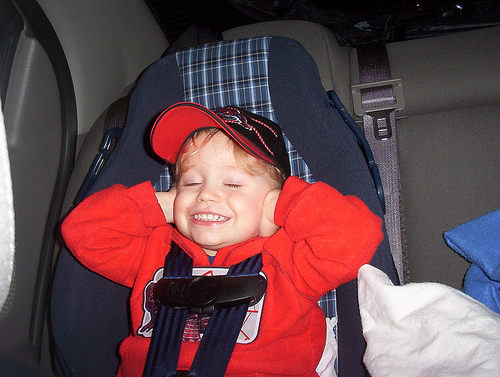

In [31]:
Image.open('../../coco-data/VOCdevkit/VOC2012/JPEGImages/2008_001510.jpg')

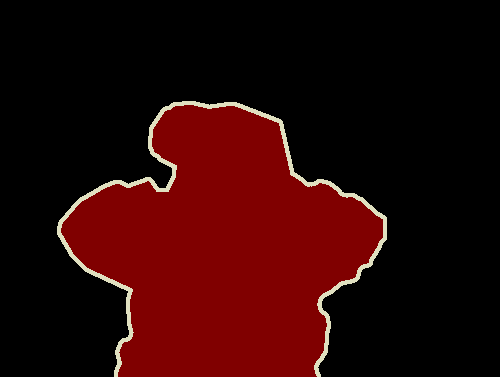

In [32]:
img = Image.open('../../coco-data/VOCdevkit/VOC2012/SegmentationObject/2008_001510.png')
img

In [33]:
np.unique(np.array(img))

array([  0,   1, 255], dtype=uint8)

In [47]:
np.where(np.array(img)==1,0,255)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]])

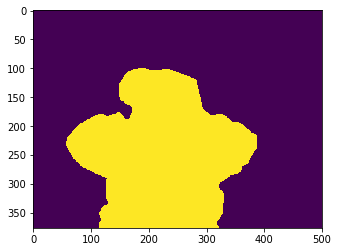

In [45]:
plt.imshow(np.where(np.array(img)==0,0,255))

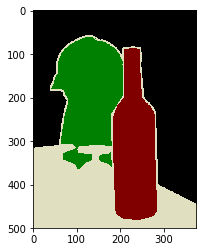

In [18]:
plt.imshow(plt.imread('../../coco-data/VOCdevkit/VOC2012/SegmentationObject/2010_003468.png').astype('float'))

In [11]:
train_image_folder = '../../coco-data/VOCdevkit/VOC2012/JPEGImages/'
train_annot_folder = '../../coco-data/VOCdevkit/VOC2012/Annotations/'

# valid_image_folder = '/home/ankish1/ankish_save/yolo/retinaNet/raccoon-data/val-images/'
# valid_annot_folder = '/home/ankish1/ankish_save/yolo/retinaNet/raccoon-data/val-annotations/'


LABELS = 'raccoon'

train_imgs, seen_train_labels = parse_annotation(train_annot_folder, train_image_folder)


In [12]:
train_imgs[:3]

[{'object': [{'name': 'person',
    'xmin': 174,
    'ymin': 101,
    'xmax': 349,
    'ymax': 351},
   {'name': 'head', 'xmin': 169, 'ymin': 104, 'xmax': 209, 'ymax': 146},
   {'name': 'hand', 'xmin': 278, 'ymin': 210, 'xmax': 297, 'ymax': 233},
   {'name': 'foot', 'xmin': 273, 'ymin': 333, 'xmax': 297, 'ymax': 354},
   {'name': 'foot', 'xmin': 319, 'ymin': 307, 'xmax': 340, 'ymax': 326}],
  'filename': '../../coco-data/VOCdevkit/VOC2012/JPEGImages/2007_000027.jpg',
  'width': 486,
  'height': 500},
 {'object': [{'name': 'aeroplane',
    'xmin': 104,
    'ymin': 78,
    'xmax': 375,
    'ymax': 183},
   {'name': 'aeroplane', 'xmin': 133, 'ymin': 88, 'xmax': 197, 'ymax': 123},
   {'name': 'person', 'xmin': 195, 'ymin': 180, 'xmax': 213, 'ymax': 229},
   {'name': 'person', 'xmin': 26, 'ymin': 189, 'xmax': 44, 'ymax': 238}],
  'filename': '../../coco-data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg',
  'width': 500,
  'height': 281},
 {'object': [{'name': 'aeroplane',
    'xmin': 9,
   

In [26]:
seen_train_labels

{'person': 17401,
 'head': 923,
 'hand': 1507,
 'foot': 643,
 'aeroplane': 1002,
 'tvmonitor': 893,
 'train': 704,
 'boat': 1059,
 'dog': 1598,
 'chair': 3056,
 'bird': 1271,
 'bicycle': 837,
 'bottle': 1561,
 'sheep': 1084,
 'diningtable': 800,
 'horse': 803,
 'motorbike': 801,
 'sofa': 841,
 'cow': 771,
 'car': 2492,
 'cat': 1277,
 'bus': 685,
 'pottedplant': 1202}

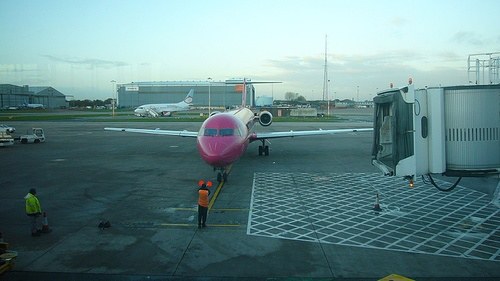

In [14]:
from PIL import Image
Image.open('../../coco-data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg')

In [14]:
train_image_folder = '/home/ankish1/ankish_save/yolo/retinaNet/raccoon-data/train-images/'
train_annot_folder = '/home/ankish1/ankish_save/yolo/retinaNet/raccoon-data/train-annotations/'

valid_image_folder = '/home/ankish1/ankish_save/yolo/retinaNet/raccoon-data/val-images/'
valid_annot_folder = '/home/ankish1/ankish_save/yolo/retinaNet/raccoon-data/val-annotations/'


LABELS = 'raccoon'

train_imgs, seen_train_labels = parse_annotation(train_annot_folder, train_image_folder, labels=LABELS)


In [15]:
train_imgs[:3]

[{'object': [{'name': 'raccoon',
    'xmin': 81,
    'ymin': 88,
    'xmax': 522,
    'ymax': 408}],
  'filename': '/home/ankish1/ankish_save/yolo/retinaNet/raccoon-data/train-images/raccoon-1.jpg',
  'width': 650,
  'height': 417},
 {'object': [{'name': 'raccoon',
    'xmin': 130,
    'ymin': 2,
    'xmax': 446,
    'ymax': 488}],
  'filename': '/home/ankish1/ankish_save/yolo/retinaNet/raccoon-data/train-images/raccoon-10.jpg',
  'width': 450,
  'height': 495},
 {'object': [{'name': 'raccoon',
    'xmin': 548,
    'ymin': 10,
    'xmax': 954,
    'ymax': 520}],
  'filename': '/home/ankish1/ankish_save/yolo/retinaNet/raccoon-data/train-images/raccoon-100.jpg',
  'width': 960,
  'height': 576}]

In [15]:
seen_train_labels

{'raccoon': 196}

In [11]:
len(train_data_prepare)

14000

In [12]:
idx = np.random.permutation(len(train_data_prepare))[:100]

temp_img = [train_data_prepare[i] for i in idx]
temp_img

[{'filename': '/home/ankish1/ankish_save/yolo/data/train/images/147742489562420161025_164410.png',
  'height': 480,
  'object': [{'name': 'obj',
    'xmax': 621,
    'xmin': 36,
    'ymax': 480,
    'ymin': 13}],
  'width': 640},
 {'filename': '/home/ankish1/ankish_save/yolo/data/train/images/1474716193690DSC07867.png',
  'height': 480,
  'object': [{'name': 'obj',
    'xmax': 593,
    'xmin': 74,
    'ymax': 405,
    'ymin': 61}],
  'width': 640},
 {'filename': '/home/ankish1/ankish_save/yolo/data/train/images/147754424432420161026_133342.png',
  'height': 480,
  'object': [{'name': 'obj',
    'xmax': 490,
    'xmin': 141,
    'ymax': 363,
    'ymin': 91}],
  'width': 640},
 {'filename': '/home/ankish1/ankish_save/yolo/data/train/images/JPEG_20161007_135017_1000335712747.png',
  'height': 480,
  'object': [{'name': 'obj',
    'xmax': 538,
    'xmin': 123,
    'ymax': 428,
    'ymin': 51}],
  'width': 640},
 {'filename': '/home/ankish1/ankish_save/yolo/data/train/images/1473660407984De

In [14]:
len(train_data_prepare)

14000

In [11]:
idx = np.random.permutation(len(train_data_prepare))
train_idx = idx[:13000]
val_idx = idx[13000:]

train_imgs = [train_data_prepare[i] for i in train_idx]
seen_train_labels = {}
seen_train_labels['obj'] = len(train_imgs)

valid_imgs = [train_data_prepare[i] for i in val_idx]
seen_valid_labels = {}
seen_valid_labels['obj'] = len(valid_imgs)

len(train_imgs), len(valid_imgs), seen_train_labels, seen_valid_labels

(13000, 1000, {'obj': 13000}, {'obj': 1000})

In [12]:
# train_image_folder = '/home/ankish1/ankish_save/yolo/retinaNet/keras-yolo2/raccoon-data/train-images/'
# train_annot_folder = '/home/ankish1/ankish_save/yolo/retinaNet/keras-yolo2/raccoon-data/train-annotations/'

# valid_image_folder = '/home/ankish1/ankish_save/yolo/retinaNet/keras-yolo2/raccoon-data/val-images/'
# valid_annot_folder = '/home/ankish1/ankish_save/yolo/retinaNet/keras-yolo2/raccoon-data/val-annotations/'




# train_imgs, seen_train_labels = parse_annotation(train_annot_folder, train_image_folder, labels=LABELS)
### write parsed annotations to pickle for fast retrieval next time
#with open('train_imgs', 'wb') as fp:
#    pickle.dump(train_imgs, fp)

### read saved pickle of parsed annotations
#with open ('train_imgs', 'rb') as fp:
#    train_imgs = pickle.load(fp)
train_batch = BatchGenerator(train_imgs, generator_config, norm=normalize)

# valid_imgs, seen_valid_labels = parse_annotation(valid_annot_folder, valid_image_folder, labels=LABELS)
### write parsed annotations to pickle for fast retrieval next time
#with open('valid_imgs', 'wb') as fp:
#    pickle.dump(valid_imgs, fp)

### read saved pickle of parsed annotations
#with open ('valid_imgs', 'rb') as fp:
#    valid_imgs = pickle.load(fp)
valid_batch = BatchGenerator(valid_imgs, generator_config, norm=normalize, jitter=False)

In [15]:
temp = BatchGenerator(train_imgs, generator_config, norm=None)


In [23]:
# (i1, b1), g1 = temp.__getitem__(0)

In [14]:
# train_imgs, seen_train_labels, valid_imgs, seen_valid_labels

**Setup a few callbacks and start the training**

In [13]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=5, 
                           mode='min', 
                           verbose=1)

checkpoint = ModelCheckpoint('weights_flipkart_new_loss_aug_again.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=4, 
                              min_lr=1e-6) 

In [18]:
tb_counter  = len([log for log in os.listdir(os.path.expanduser('./logs/')) if 'flipkart' in log]) + 1
tensorboard = TensorBoard(log_dir=os.path.expanduser('~/logs/') + 'flipkart' + '_' + str(tb_counter), 
                          histogram_freq=0, 
                          write_graph=True, 
                          write_images=False)



In [14]:
from __future__ import print_function

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
#optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss=custom_loss, optimizer=optimizer)

model.fit_generator(generator        = train_batch, 
                    steps_per_epoch  = len(train_batch), 
                    epochs           = 160, 
                    verbose          = 1,
                    validation_data  = valid_batch,
                    validation_steps = len(valid_batch),
                    callbacks        = [early_stop, checkpoint, reduce_lr],#tensorboard], 
                    max_queue_size   = 3)

Epoch 1/160
407/407 [==============================] - 965s 2s/step - loss: 94.6697 - val_loss: 45.4934

Epoch 00001: val_loss improved from inf to 45.49338, saving model to weights_flipkart_new_loss_aug_again.h5
Epoch 2/160
407/407 [==============================] - 180s 441ms/step - loss: 44.5458 - val_loss: 39.7421

Epoch 00002: val_loss improved from 45.49338 to 39.74215, saving model to weights_flipkart_new_loss_aug_again.h5
Epoch 3/160
407/407 [==============================] - 180s 443ms/step - loss: 38.3719 - val_loss: 35.8589

Epoch 00003: val_loss improved from 39.74215 to 35.85891, saving model to weights_flipkart_new_loss_aug_again.h5
Epoch 4/160
407/407 [==============================] - 175s 430ms/step - loss: 32.3535 - val_loss: 33.0249

Epoch 00004: val_loss improved from 35.85891 to 33.02493, saving model to weights_flipkart_new_loss_aug_again.h5
Epoch 5/160
407/407 [==============================] - 181s 445ms/step - loss: 26.8329 - val_loss: 25.8446

Epoch 00005: val

Epoch 39/160
407/407 [==============================] - 194s 477ms/step - loss: 0.4134 - val_loss: 0.4899

Epoch 00039: val_loss did not improve from 0.41888
Epoch 40/160
407/407 [==============================] - 193s 475ms/step - loss: 0.3616 - val_loss: 0.3942

Epoch 00040: val_loss improved from 0.41888 to 0.39419, saving model to weights_flipkart_new_loss_aug_again.h5
Epoch 41/160
407/407 [==============================] - 192s 472ms/step - loss: 0.3260 - val_loss: 0.3628

Epoch 00041: val_loss improved from 0.39419 to 0.36276, saving model to weights_flipkart_new_loss_aug_again.h5
Epoch 42/160
407/407 [==============================] - 194s 478ms/step - loss: 0.3040 - val_loss: 0.3526

Epoch 00042: val_loss improved from 0.36276 to 0.35264, saving model to weights_flipkart_new_loss_aug_again.h5
Epoch 43/160
407/407 [==============================] - 193s 474ms/step - loss: 0.2803 - val_loss: 0.3596

Epoch 00043: val_loss did not improve from 0.35264
Epoch 44/160
407/407 [========

In [15]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open("model_dir/model-flipkart-baseline1-aug-reduce-lr-200-epoch.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("model_dir/model-flipkart-baseline1-aug-reduce-lr-200-epoch.h5")
print("Saved model to disk")

Saved model to disk


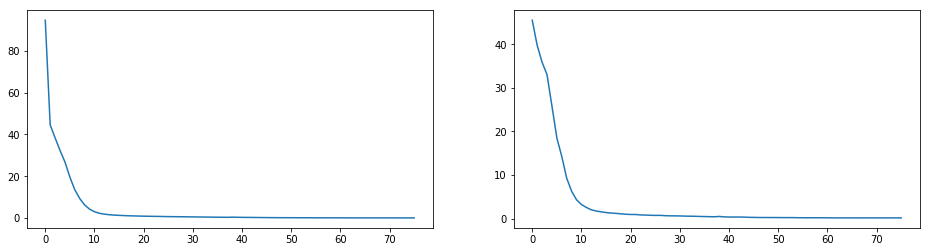

In [16]:
fig, ax = plt.subplots(1,2,figsize=(16,4))
ax[0].plot(model.history.history['loss'])
ax[1].plot(model.history.history['val_loss'])


# Perform detection on image

In [18]:
# model.load_weights("weights_raccoon.h5")

In [29]:
OBJ_THRESHOLD, NMS_THRESHOLD

(0.3, 0.3)

In [34]:
len(os.listdir('/home/ankish1/ankish_save/yolo/data/test/'))

12815

In [255]:
len(boxes)

2

In [264]:
def predict(test_img):
    image = cv2.imread(test_img)
    input_image = cv2.resize(image, (224, 224))
    input_image = input_image / 255.
    input_image = input_image[:,:,::-1]
    input_image = np.expand_dims(input_image, 0)

    dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))
    
    netout = model.predict([input_image, dummy_array])

    boxes = decode_netout(netout[0], 
                          obj_threshold=OBJ_THRESHOLD,
                          nms_threshold=NMS_THRESHOLD,
                          anchors=ANCHORS, 
                          nb_class=CLASS)
#     print(boxes)
    if len(boxes)>1:
        score_ = boxes[0].get_score()
        index_  = 0
        for ii, bb in enumerate(boxes[1:]):
            score_1 = bb.get_score()
            if score_1>=score_:
                index_ = ii
                score_ = score_1
#         print(index_)
        return boxes[index_]
    else:
        return boxes
# predict('/home/ankish1/ankish_save/yolo/data/test/1480966730545TotetecaModelShoot12249.png')

## 149/11778 are empty..... Fill it with full image dimensions

In [267]:
box_pred = []

test_dir = '/home/ankish1/ankish_save/yolo/data/test/'

df_test = pd.read_csv('/home/ankish1/ankish_save/yolo/data/test.csv')
all_files = df_test['image_name'].values

# all_files = os.listdir(test_dir)

for ii, file_ in enumerate(all_files):
    box_pred.append(predict(test_dir + file_))
    if (ii%2000) == 0:
        print("done till {} images".format(ii))
                           
#     if ii == 5:
#         break

done till 0 images
done till 2000 images
done till 4000 images
done till 6000 images
done till 8000 images
done till 10000 images
done till 12000 images


In [266]:
len(box_pred), np.array(box_pred).shape

(326, (326,))

In [268]:
len(box_pred), np.array(box_pred).shape

(12815, (12815,))

In [280]:
box_[0].get_score()

0.9403908

In [291]:
if not box_:
    print("hey")

hey


In [310]:
box_pred1 = box_pred
count = 0
for ii, box_ in enumerate(box_pred1):
    if box_:
        try:
#             print(box_[0])
            count += 1
        except:
#             print(box_)
            count += 1
count

12657

In [301]:
count = 0
for ii, box_ in enumerate(box_pred):
    if not box_:
        count += 1
count

158

In [311]:
empty_pred_idx = []
box_pred_values = []
count = 0
for ii, box_ in enumerate(box_pred):
    image_h, image_w = 480, 640
#     if not box_:
#         print(ii)
#         count += 1
# count
    if box_:
        try:
#             print(box_[0])
            xmin = int(box_[0].xmin * image_w)
            ymin = int(box_[0].ymin * image_h)
            xmax = int(box_[0].xmax * image_w)
            ymax = int(box_[0].ymax * image_h)
        except:
#             print(box_)
            xmin = int(box_.xmin * image_w)
            ymin = int(box_.ymin * image_h)
            xmax = int(box_.xmax * image_w)
            ymax = int(box_.ymax * image_h)
#     if box_:
#         xmin = int(box_[0].xmin * image_w)
#         ymin = int(box_[0].ymin * image_h)
#         xmax = int(box_[0].xmax * image_w)
#         ymax = int(box_[0].ymax * image_h)
    
#     elif:
#         xmin = int(box_.xmin * image_w)
#         ymin = int(box_.ymin * image_h)
#         xmax = int(box_.xmax * image_w)
#         ymax = int(box_.ymax * image_h)
    else:
        empty_pred_idx.append(ii)
        xmin, ymin, xmax, ymax = 999, 999, 999, 999#0, 0, 640, 480
    box_pred_values.append((xmin, ymin, xmax, ymax))
    
box_pred_values = np.array(box_pred_values)
box_pred_values[3], box_pred_values.shape

(array([203,  90, 463, 416]), (12815, 4))

In [298]:
box_

<utils.BoundBox instance at 0x7ef92f8da3b0>

In [312]:
df_pred = pd.DataFrame(columns=['x1','y1','x2','y2'], data=box_pred_values)
df_pred.head()

x1   y1   x2   y2
0  232   93  451  415
1   77  131  577  351
2  134   40  481  421
3  203   90  463  416
4  110   43  492  450

In [313]:
df_img = pd.DataFrame(data=all_files, columns=['image_name'])

sub = pd.concat([df_img, df_pred['x1'], df_pred['x2'], df_pred['y1'], df_pred['y2']], axis=1)
sub.head()

image_name   x1   x2   y1   y2
0               1474723840903DSC08089.png  232  451   93  415
1        1473231475010DeeplearnS11276.png   77  577  131  351
2  JPEG_20161205_135307_1000155917326.png  134  481   40  421
3  JPEG_20160711_123440_1000518778437.png  203  463   90  416
4   JPEG_20160803_115329_100034020722.png  110  492   43  450

In [314]:
sub.to_csv("flipkart-corrected-formated.csv", index=None)

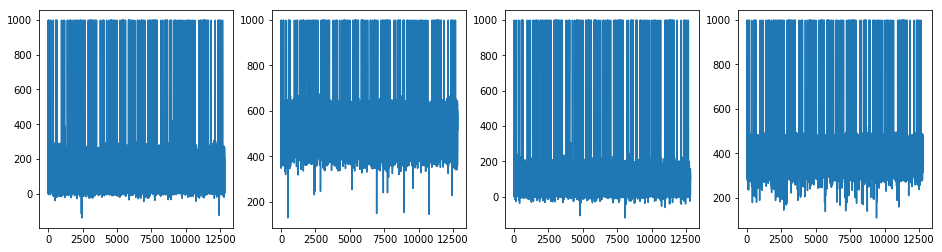

In [316]:
fig, ax = plt.subplots(1,4, figsize=(16,4))
axes = ax.flatten()
axes[0].plot(sub.x1)
axes[1].plot(sub.x2)
axes[2].plot(sub.y1)
axes[3].plot(sub.y2)


In [345]:
sub[sub.x1 == 999].shape, sub[sub.y1 == 999].shape, sub[sub.x2 == 999].shape, sub[sub.y2 == 999].shape

((158, 5), (158, 5), (158, 5), (158, 5))

In [322]:
sub[sub.x1 != 999][['x1','x2','y1','y2']].mean()

x1    113.386822
x2    525.661373
y1     84.116220
y2    389.024729
dtype: float64

In [324]:
sub_save_copy = sub.copy()

In [344]:
sub = sub_save_copy

In [340]:
# sub.x1 = sub[sub.x1 == 999][['x1']].replace([999],99999)
# sub[sub.x1 == 99999][['x1']]

In [347]:
# sub[sub.x1 == 999][['x1']] = sub[sub.x1 == 999][['x1']].replace([999],113.386822)
# sub[sub.x2 == 999][['x2']] = sub[sub.x2 == 999][['x2']].replace([999],525.661373)
# sub[sub.y1 == 999][['y1']] = sub[sub.y1 == 999][['y1']].replace([999],84.116220)
# sub[sub.y2 == 999][['y2']] = sub[sub.y2 == 999][['y2']].replace([999],389.024729)

In [348]:
sub.head()

image_name   x1   x2   y1   y2
0               1474723840903DSC08089.png  232  451   93  415
1        1473231475010DeeplearnS11276.png   77  577  131  351
2  JPEG_20161205_135307_1000155917326.png  134  481   40  421
3  JPEG_20160711_123440_1000518778437.png  203  463   90  416
4   JPEG_20160803_115329_100034020722.png  110  492   43  450

In [353]:
sub.x1 = np.where(sub.x1==999,113,sub.x1)
sub.y1 = np.where(sub.y1==999, 84, sub.y1)
sub.x2 = np.where(sub.x2==999, 526, sub.x2)
sub.y2 = np.where(sub.y2==999, 389, sub.y2)


In [356]:
# sub[sub.y2 == 999]

Empty DataFrame
Columns: [image_name, x1, x2, y1, y2]
Index: []

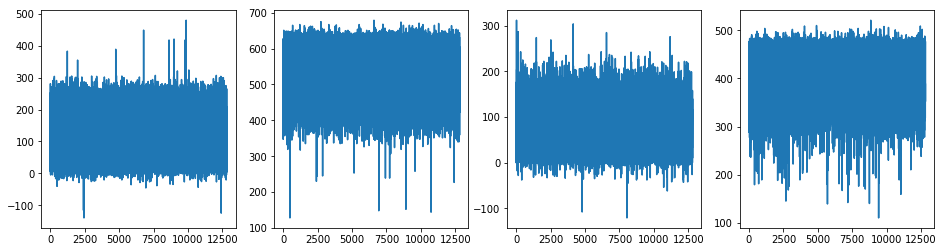

In [357]:
fig, ax = plt.subplots(1,4, figsize=(16,4))
axes = ax.flatten()
axes[0].plot(sub.x1)
axes[1].plot(sub.x2)
axes[2].plot(sub.y1)
axes[3].plot(sub.y2)


In [364]:
sub.x1 = np.where(sub.x1<-1,-1,sub.x1)
sub.y1 = np.where(sub.y1<-1, -1, sub.y1)
sub.x2 = np.where(sub.x2>640, 640, sub.x2)
sub.y2 = np.where(sub.y2>480, 480, sub.y2)


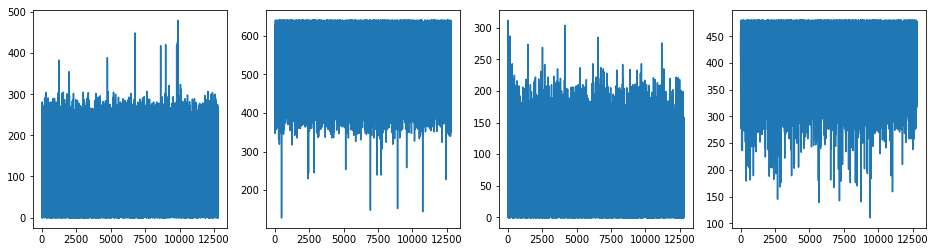

In [365]:
fig, ax = plt.subplots(1,4, figsize=(16,4))
axes = ax.flatten()
axes[0].plot(sub.x1)
axes[1].plot(sub.x2)
axes[2].plot(sub.y1)
axes[3].plot(sub.y2)


In [367]:
sub.to_csv('flipkart_final_corrected.csv',index=None)

In [204]:
df_train = pd.read_csv('/home/ankish1/ankish_save/yolo/data/training.csv')
df_train.head()

image_name   x1   x2   y1   y2
0             JPEG_20160706_121146_1000145715002.png  115  495  143  325
1             JPEG_20161119_174038_1000690577600.png   23  457   61  409
2  147444927651111470309333776-Roadster-Men-Casua...   37  601   13  470
3                   147772332675720161028_161611.png   27  602  162  385
4                   1473315333651DeeplearnS11638.png   60  586  174  325

In [206]:
df_train.x1.min(), df_train.x1.max(), df_train.x2.min(), df_train.x2.max()

(-1, 524, 145, 640)

In [207]:
df_train.y1.min(), df_train.y1.max(), df_train.y2.min(), df_train.y2.max()

(-1, 468, 159, 480)

In [217]:
# sub.x1 = sub.x1[sub.x1 <-1]
temp_sub = sub.copy()
temp_sub.y1 = np.where(temp_sub.y1<-1,-1,temp_sub.y1)
temp_sub.y1.min(), temp_sub.y1.max()

(-1, 312)

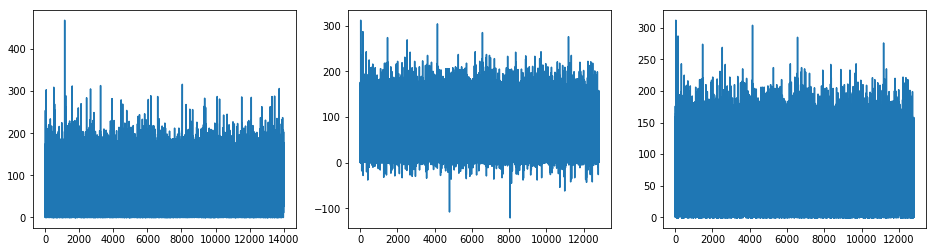

In [222]:
fig, ax = plt.subplots(1,3, figsize=(16,4))
axes = ax.flatten()
axes[0].plot(df_train.y1)
axes[1].plot(sub.y1)
axes[2].plot(temp_sub.y1)


In [225]:
# sub.x1 = sub.x1[sub.x1 <-1]
temp_sub = sub.copy()
print("before: ",temp_sub.x2.min(), temp_sub.x2.max())
temp_sub.x2 = np.where(temp_sub.x2>640,640,temp_sub.x2)
print("after: ",temp_sub.x2.min(), temp_sub.x2.max())

before:  128 679
after:  128 640


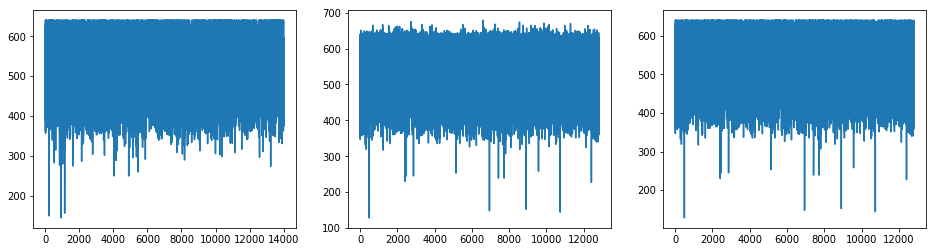

In [226]:
fig, ax = plt.subplots(1,3, figsize=(16,4))
axes = ax.flatten()
axes[0].plot(df_train.x2)
axes[1].plot(sub.x2)
axes[2].plot(temp_sub.x2)


before:  110 521
after:  110 480


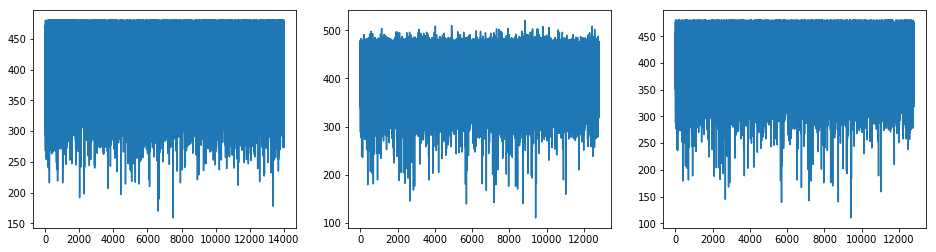

In [227]:
# sub.x1 = sub.x1[sub.x1 <-1]
temp_sub = sub.copy()
print("before: ",temp_sub.y2.min(), temp_sub.y2.max())
temp_sub.y2 = np.where(temp_sub.y2>480,480,temp_sub.y2)
print("after: ",temp_sub.y2.min(), temp_sub.y2.max())

fig, ax = plt.subplots(1,3, figsize=(16,4))
axes = ax.flatten()
axes[0].plot(df_train.y2)
axes[1].plot(sub.y2)
axes[2].plot(temp_sub.y2)


In [228]:
sub_save = sub.copy()

In [230]:
sub_save.head()

image_name   x1   x2   y1   y2
0               1474723840903DSC08089.png  232  451   93  415
1        1473231475010DeeplearnS11276.png   77  577  131  351
2  JPEG_20161205_135307_1000155917326.png  134  481   40  421
3  JPEG_20160711_123440_1000518778437.png  203  463   90  416
4   JPEG_20160803_115329_100034020722.png  110  492   43  450

In [229]:
print("before: ",sub.x1.min(), sub.y1.min(), sub.x2.max(), sub.y2.max())

sub.x1 = np.where(sub.x1<-1,-1,sub.x1)
sub.y1 = np.where(sub.y1<-1,-1,sub.y1)
sub.x2 = np.where(sub.x2>640,640,sub.x2)
sub.y2 = np.where(sub.y2>480,480,sub.y2)

print("before: ",sub.x1.min(), sub.y1.min(), sub.x2.max(), sub.y2.max())


before:  -140 -121 679 521
before:  -1 -121 640 480


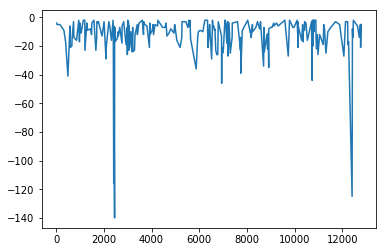

In [233]:
plt.plot(sub.x1[sub.x1<-1])

In [234]:
sub.x1[sub.x1<-50]

2413    -116
2448    -140
12415   -125
Name: x1, dtype: int64

In [241]:
sub.iloc[2413], sub.iloc[2448], sub.iloc[12415]

(image_name    1473747680297IMG_0532.png
 x1                                 -116
 x2                                  230
 y1                                  191
 y2                                  301
 Name: 2413, dtype: object, image_name    1467548589518Odomos-Oil-Pack.png
 x1                                        -140
 x2                                         244
 y1                                          33
 y2                                         440
 Name: 2448, dtype: object, image_name    1480966730545TotetecaModelShoot12249.png
 x1                                                -125
 x2                                                 227
 y1                                                 178
 y2                                                 294
 Name: 12415, dtype: object)

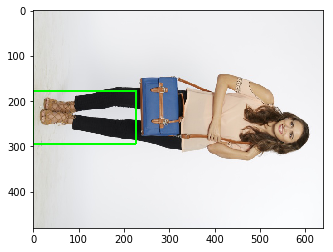

In [368]:
idx_r = 12415#np.random.randint(sub.shape[0])
# now
image = cv2.imread(test_dir + all_files[idx_r])
box__ = sub.iloc[idx_r]
xmin, ymin, xmax, ymax = box__['x1'], box__['y1'], box__['x2'],box__['y2']

image = cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,255,0), 3)
plt.imshow(image[:,:,::-1]); plt.show()

In [372]:
def predict(test_img):
    image = cv2.imread(test_img)
    input_image = cv2.resize(image, (224, 224))
    input_image = input_image / 255.
    input_image = input_image[:,:,::-1]
    input_image = np.expand_dims(input_image, 0)

    dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))
    
    netout = model.predict([input_image, dummy_array])

    boxes = decode_netout(netout[0], 
                          obj_threshold=OBJ_THRESHOLD,
                          nms_threshold=NMS_THRESHOLD,
                          anchors=ANCHORS, 
                          nb_class=CLASS)
#     print(boxes)
    if len(boxes)>1:
        score_ = boxes[0].get_score()
        print(score_)
        index_  = 0
        for ii, bb in enumerate(boxes[1:]):
            score_1 = bb.get_score()
            print(score_1)
            if score_1>=score_:
                index_ = ii+1
                score_ = score_1
#         print(index_)
        print(index_)
        return boxes[index_]
    else:
        return boxes
    
bbb = predict(test_dir + all_files[idx_r])

# predict('/home/ankish1/ankish_save/yolo/data/test/1480966730545TotetecaModelShoot12249.png')

0.32943097
0.9652442
0


In [370]:
bbb = predict(test_dir + all_files[idx_r])
bbb.get_score()

0.32943097

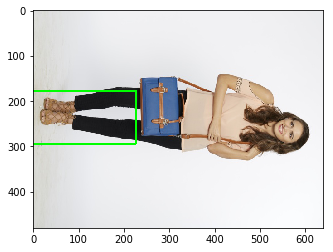

In [238]:
idx_r = 12415#np.random.randint(sub.shape[0])
# now
image = cv2.imread(test_dir + all_files[idx_r])
box__ = sub.iloc[idx_r]
xmin, ymin, xmax, ymax = box__['x1'], box__['y1'], box__['x2'],box__['y2']

image = cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,255,0), 3)
plt.imshow(image[:,:,::-1]); plt.show()

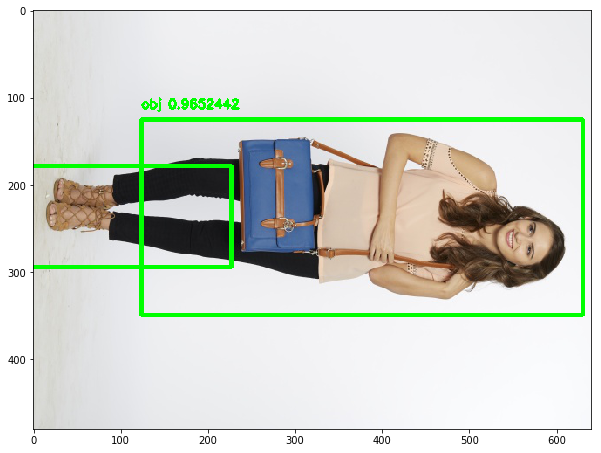

In [252]:
# now
image = cv2.imread('/home/ankish1/ankish_save/yolo/data/test/1480966730545TotetecaModelShoot12249.png')

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

In [253]:
boxes[0].get_score(),boxes[1].get_score()

(0.32943097, 0.9652442)

In [249]:
box_pred_values[12415]

array([-125,  178,  227,  294])

In [23]:
sub.to_csv('flipkart_baseline_loss_weight_recent.csv',index=None)

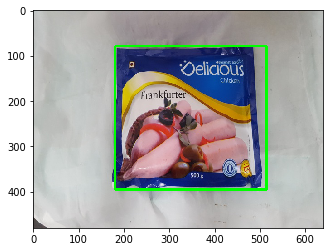

In [24]:
idx_r = np.random.randint(sub.shape[0])
# now
image = cv2.imread(test_dir + all_files[idx_r])
box__ = sub.iloc[idx_r]
xmin, ymin, xmax, ymax = box__['x1'], box__['y1'], box__['x2'],box__['y2']

image = cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,255,0), 3)
plt.imshow(image[:,:,::-1]); plt.show()

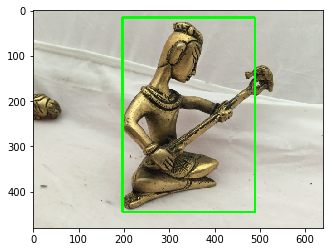

In [25]:
idx_r = np.random.randint(sub.shape[0])
# now
image = cv2.imread(test_dir + all_files[idx_r])
box__ = sub.iloc[idx_r]
xmin, ymin, xmax, ymax = box__['x1'], box__['y1'], box__['x2'],box__['y2']

image = cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,255,0), 3)
plt.imshow(image[:,:,::-1]); plt.show()

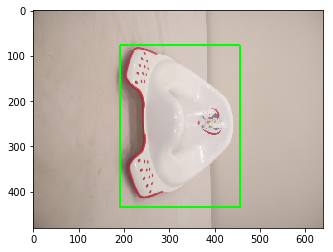

In [31]:
idx_r = np.random.randint(sub.shape[0])
# now
image = cv2.imread(test_dir + all_files[idx_r])
box__ = sub.iloc[idx_r]
xmin, ymin, xmax, ymax = box__['x1'], box__['y1'], box__['x2'],box__['y2']

image = cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,255,0), 3)
plt.imshow(image[:,:,::-1]); plt.show()

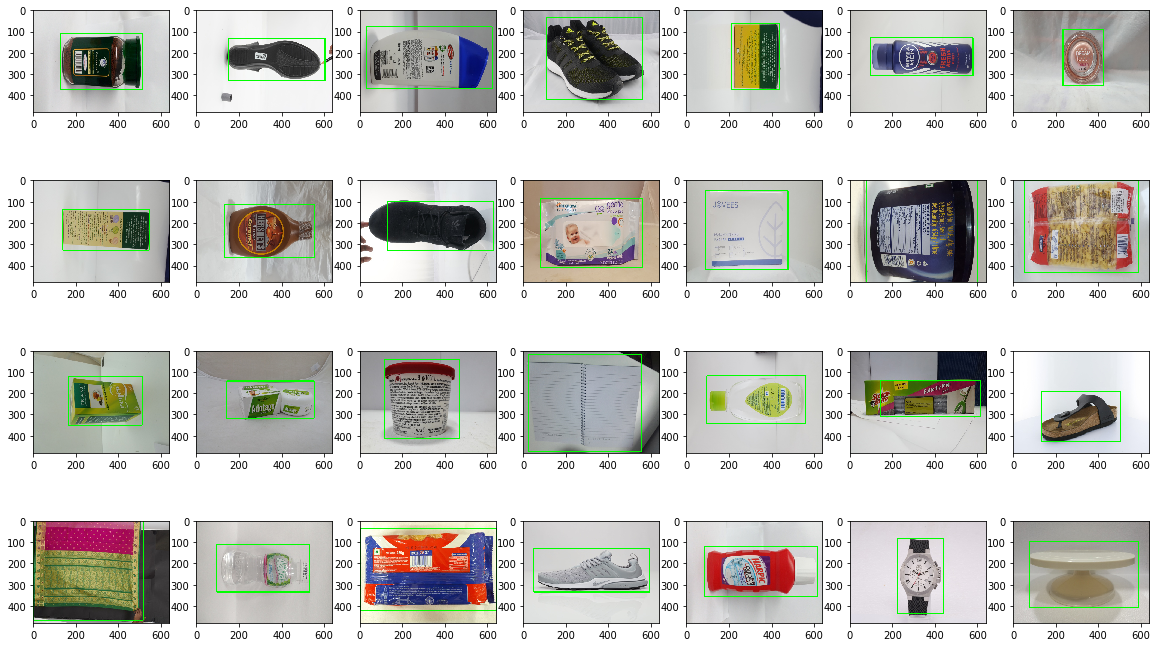

In [56]:
fig, ax = plt.subplots(4,7,figsize=(20,12))
axes = ax.flatten()

for i in range(28):
    idx_r = np.random.randint(sub.shape[0])
    # now
    image = cv2.imread(test_dir + all_files[idx_r])
    box__ = sub.iloc[idx_r]
    xmin, ymin, xmax, ymax = box__['x1'], box__['y1'], box__['x2'],box__['y2']

    image = cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,255,0), 3)
    axes[i].imshow(image[:,:,::-1])
plt.show()

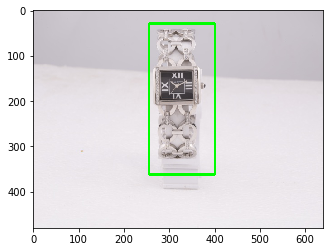

In [137]:
idx_r = np.random.randint(sub.shape[0])
# now
image = cv2.imread(test_dir + all_files[idx_r])
box__ = sub.iloc[idx_r]
xmin, ymin, xmax, ymax = box__['x1'], box__['y1'], box__['x2'],box__['y2']

image = cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,255,0), 3)
plt.imshow(image[:,:,::-1]); plt.show()

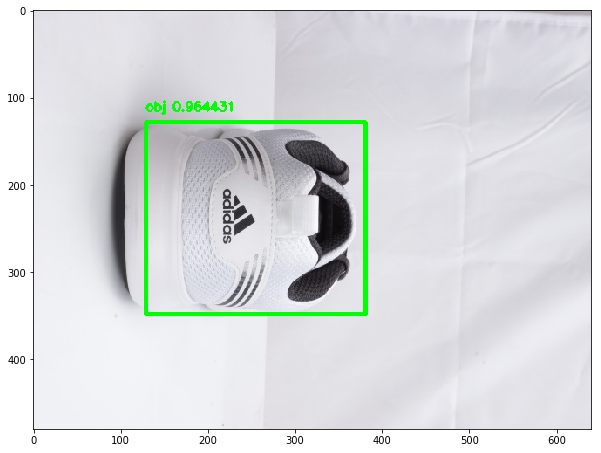

In [120]:
idx_r = np.random.randint(sub.shape[0])
# now
image = cv2.imread(test_dir + all_files[idx_r])

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

image = draw_boxes(image, box_pred[idx_r], labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

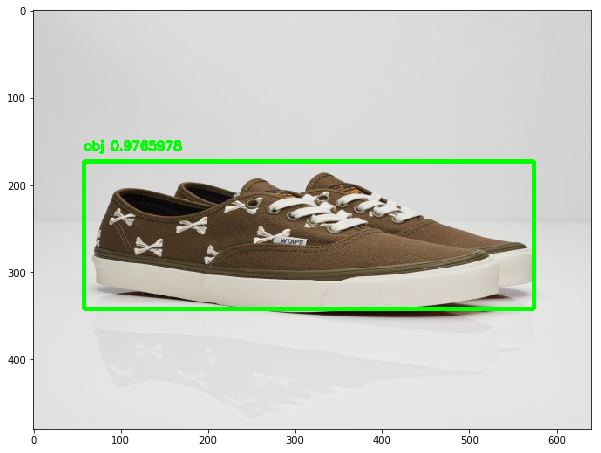

In [64]:
# now
image = cv2.imread('/home/ankish1/ankish_save/yolo/data/test/1473315187100DeeplearnS11562.png')

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

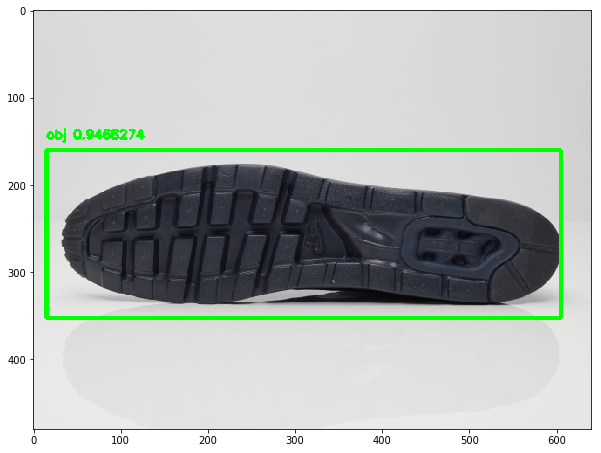

In [60]:
# now
image = cv2.imread('/home/ankish1/ankish_save/yolo/data/test/1473314786460DeeplearnS11737.png')

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

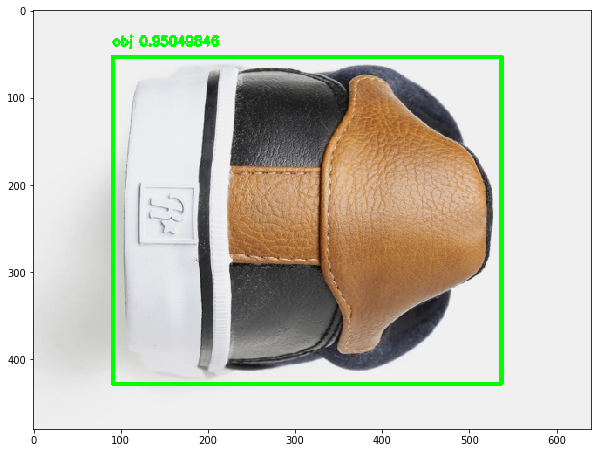

In [58]:
# now
image = cv2.imread('/home/ankish1/ankish_save/yolo/data/test/147443970409211472469737128-Roadster-Men-Black-Sneakers-4601472469737046-4.png')

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

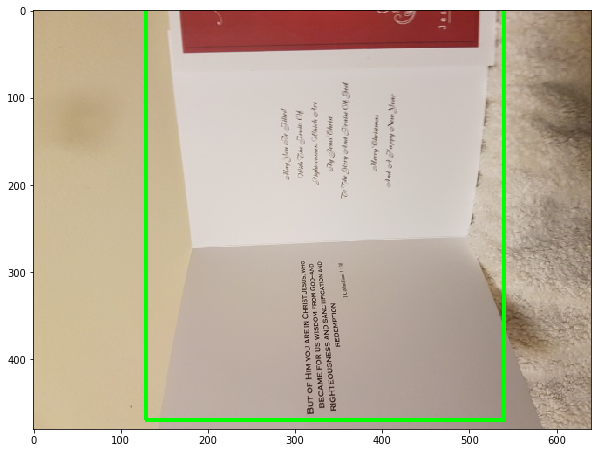

In [55]:
# now
image = cv2.imread('/home/ankish1/ankish_save/yolo/data/test/JPEG_20161207_150228_1000551221707.png')

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

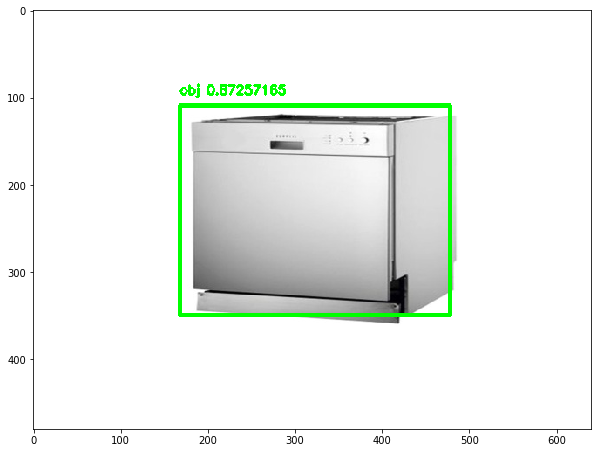

In [27]:
# now
image = cv2.imread('/home/ankish1/ankish_save/yolo/data/test/14581478679181.png')

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

In [33]:
boxes[0].xmin

0.26252042924262786

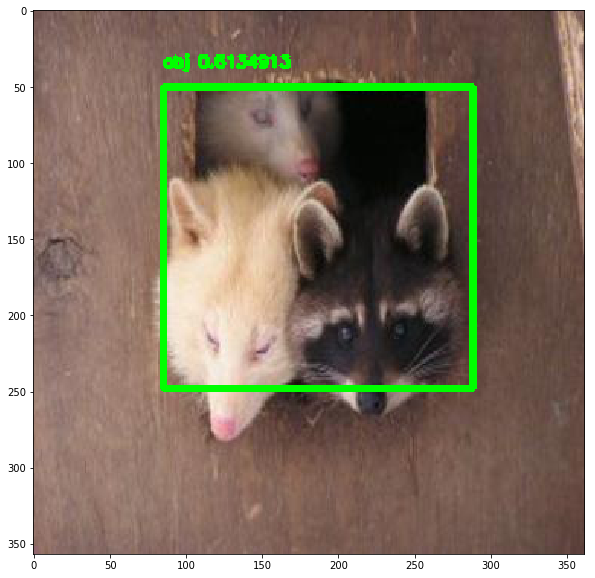

In [23]:
# now
image = cv2.imread('/home/ankish1/ankish_save/yolo/retinaNet/keras-yolo2/raccoon-data/val-images/raccoon-187.jpg')

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

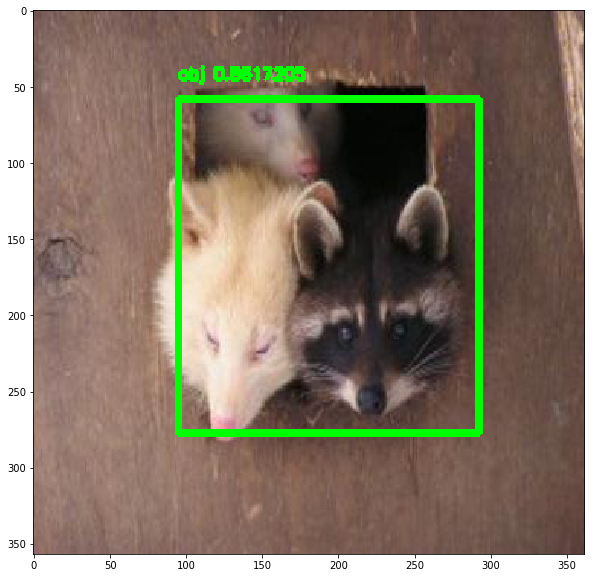

In [54]:
image = cv2.imread('/home/ankish1/ankish_save/yolo/retinaNet/raccoon-data/val-images/raccoon-187.jpg')

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

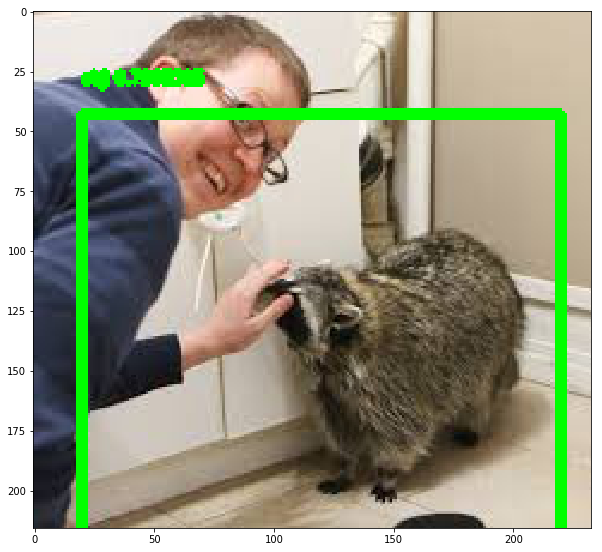

In [24]:
# now
image = cv2.imread('/home/ankish1/ankish_save/yolo/retinaNet/keras-yolo2/raccoon-data/val-images/raccoon-196.jpg')

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=0.3,
                      nms_threshold=0.3,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

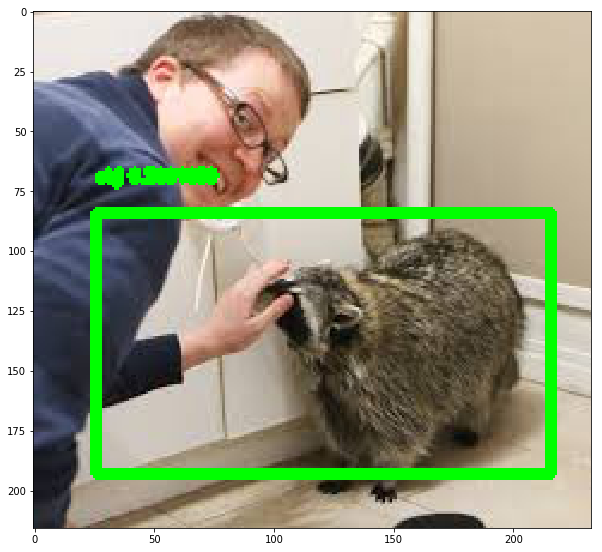

In [52]:
image = cv2.imread('/home/ankish1/ankish_save/yolo/retinaNet/raccoon-data/val-images/raccoon-196.jpg')

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=0.3,
                      nms_threshold=0.3,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

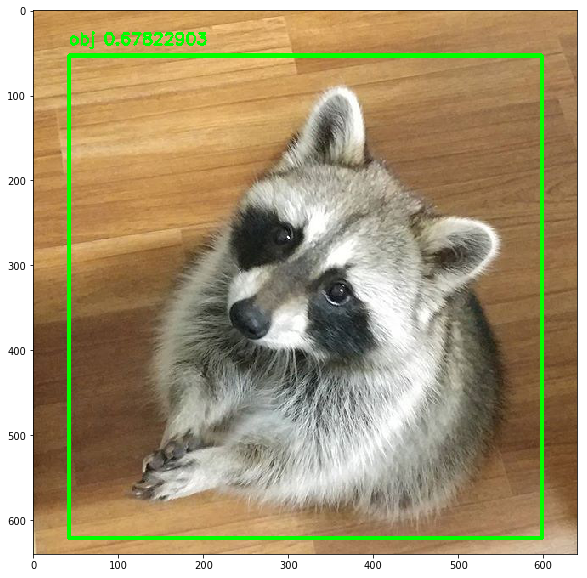

In [25]:
# now
image = cv2.imread('/home/ankish1/ankish_save/yolo/retinaNet/keras-yolo2/raccoon-data/val-images/raccoon-184.jpg')


dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=0.3,
                      nms_threshold=0.3,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

In [44]:
os.listdir('/home/ankish1/ankish_save/yolo/retinaNet/raccoon-data')

['train-images', 'val-annotations', 'train-annotations', 'val-images']

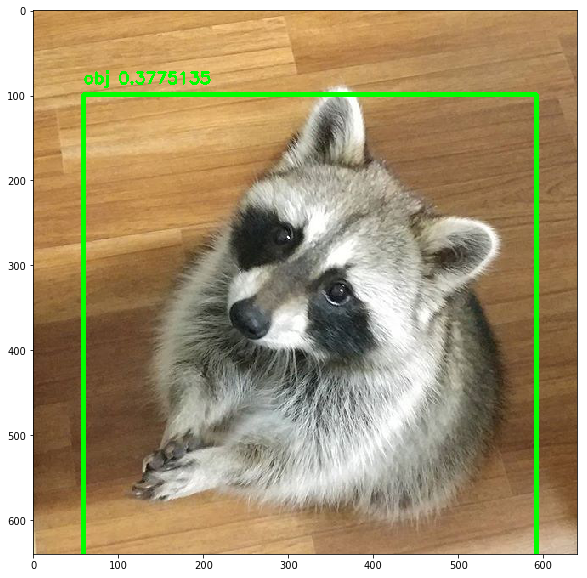

In [172]:
image = cv2.imread('/home/ankish1/ankish_save/yolo/retinaNet/raccoon-data/val-images/raccoon-184.jpg')


dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=0.3,
                      nms_threshold=0.3,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

In [50]:
boxes[0].xmax, boxes[0].ymax

(0.9263750586394807, 1.0329942417602518)

In [ ]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
weights = layer_dict['some_name'].get_weights()

In [59]:
for lay in model.layers:
    print(lay.name)

input_1
model_1
DetectionLayer
reshape_1
input_2
lambda_1


In [141]:
model.layers

In [82]:
model.layers[2].get_weights()[0].shape, model.layers[2].get_weights()[1].shape

((1, 1, 1024, 60), (60,))

In [84]:
model.layers[1].get_weights()[0].shape, model.layers[1].get_weights()[1].shape,model.layers[1].get_weights()[2].shape, model.layers[1].get_weights()[3].shape

((3, 3, 3, 32), (32,), (32,), (3, 3, 32, 1))

In [65]:
model.layers[2].output, model.layers[2].input

(<tf.Tensor 'DetectionLayer/BiasAdd:0' shape=(?, 7, 7, 60) dtype=float32>,
 <tf.Tensor 'model_1/mobilenet_1.00_224/conv_pw_13_relu/Relu6:0' shape=(?, 7, 7, 1024) dtype=float32>)

In [91]:
f[a_group_key[0].encode('utf-8')], f[a_group_key[-2].encode('utf-8')]

(<HDF5 group "/DetectionLayer" (1 members)>,
 <HDF5 group "/model_1" (54 members)>)

In [92]:
data1 = f[a_group_key[0].encode('utf-8')]

In [97]:
for i in data1:
    print(i)
data1

DetectionLayer


<HDF5 group "/DetectionLayer" (1 members)>

In [102]:
f['DetectionLayer']

<HDF5 group "/DetectionLayer" (1 members)>

In [104]:
for key in f['DetectionLayer'].keys():
    item = f['DetectionLayer'][key]

In [107]:
for key in f['DetectionLayer/DetectionLayer'].keys():
    item = f['DetectionLayer/DetectionLayer'][key]
    print(item)

<HDF5 dataset "bias:0": shape (60,), type "<f4">
<HDF5 dataset "kernel:0": shape (1, 1, 1024, 60), type "<f4">


In [108]:
for key in f['DetectionLayer/DetectionLayer/bias:0'].keys():
    item = f['DetectionLayer/DetectionLayer/bias:0'][key]
    print(item)

AttributeError: 'Dataset' object has no attribute 'keys'

In [110]:
item = f['DetectionLayer/DetectionLayer/bias:0']
item

<HDF5 dataset "bias:0": shape (60,), type "<f4">

In [133]:
import h5py

def traverse_datasets(hdf_file):

    def h5py_dataset_iterator(g, prefix=''):
        for key in g.keys():
            item = g[key]
            path = '{0}/{1}'.format(prefix, key)#{prefix}/{key}
            if isinstance(item, h5py.Dataset): # test for dataset
                yield (path, item)
            elif isinstance(item, h5py.Group): # test for group (go down)
                yield from h5py_dataset_iterator(item, path)

    with h5py.File(hdf_file, 'r') as f:
        for path, _ in h5py_dataset_iterator(f):
            yield path


with h5py.File(filename, 'r') as f:
    for dset in traverse_datasets(filename):
        print('Path:', dset)
        print('Shape:', f[dset].shape)
        print('Data type:', f[dset].dtype)

SyntaxError: invalid syntax (<ipython-input-133-307ecd0dedc6>, line 12)

In [142]:
# list(f.keys())

In [122]:
for i in f['DetectionLayer/DetectionLayer']:
    print(i)

bias:0
kernel:0


In [143]:
# f['DetectionLayer/DetectionLayer/bias:0']

In [124]:
f['DetectionLayer/DetectionLayer/kernel:0']

<HDF5 dataset "kernel:0": shape (1, 1, 1024, 60), type "<f4">

In [144]:
# dd = f['DetectionLayer/DetectionLayer/kernel:0']
# dd.shape

In [134]:
dd[:]

array([[[[-0.00606491,  0.00262099,  0.0095773 , ..., -0.02415695,
          -0.13527311, -0.00265514],
         [ 0.05260717,  0.02117084,  0.01130214, ..., -0.00308779,
          -0.17851871, -0.01809242],
         [-0.00526358,  0.00677189, -0.02778612, ...,  0.00545123,
          -0.0911043 ,  0.03243085],
         ...,
         [ 0.04759595,  0.00844085, -0.0047488 , ..., -0.00387529,
          -0.16492987, -0.01183029],
         [-0.02011492, -0.00993774,  0.02999189, ...,  0.00721365,
          -0.03635771, -0.03270813],
         [ 0.02792751,  0.00585388,  0.00770297, ...,  0.01173772,
          -0.00785354, -0.02038392]]]], dtype=float32)

In [80]:
import h5py
filename = 'model_dir/model-flipkart-baseline1-aug-reduce-lr-200-epoch.h5'
f = h5py.File(filename, 'r')

# List all groups
print("Keys: %s" % f.keys())
a_group_key = list(f.keys())

# # Get the data
# data = list(f[a_group_key])

Keys: [u'DetectionLayer', u'input_1', u'input_2', u'lambda_1', u'model_1', u'reshape_1']


In [145]:
# data = list(f[a_group_key])
# data

In [79]:
f.keys()

[u'DetectionLayer',
 u'input_1',
 u'input_2',
 u'lambda_1',
 u'model_1',
 u'reshape_1']

In [148]:
loaded_model.layers

In [150]:
loaded_model.layers[-4].get_weights()

[array([[[[ 0.01277162, -0.0189517 ,  0.00565232, ..., -0.00891411,
            0.00174567,  0.04581917],
          [ 0.00755542, -0.00181379, -0.00793453, ..., -0.01055611,
            0.07037222, -0.027066  ],
          [ 0.00076826, -0.00964658, -0.04264208, ..., -0.05546059,
           -0.03397919, -0.00752808],
          ...,
          [ 0.0623925 , -0.01999652, -0.00458662, ...,  0.00298378,
           -0.0189667 , -0.01939214],
          [-0.06364993,  0.01008745,  0.04686773, ..., -0.01573988,
            0.01065724, -0.03240918],
          [-0.01672276, -0.05009678, -0.05804484, ..., -0.05510057,
           -0.04245311,  0.05275305]]]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)]

In [151]:
model.layers[-4].get_weights()

[array([[[[-0.00606491,  0.00262099,  0.0095773 , ..., -0.02415695,
           -0.13527311, -0.00265514],
          [ 0.05260717,  0.02117084,  0.01130214, ..., -0.00308779,
           -0.17851871, -0.01809242],
          [-0.00526358,  0.00677189, -0.02778612, ...,  0.00545123,
           -0.0911043 ,  0.03243085],
          ...,
          [ 0.04759595,  0.00844085, -0.0047488 , ..., -0.00387529,
           -0.16492987, -0.01183029],
          [-0.02011492, -0.00993774,  0.02999189, ...,  0.00721365,
           -0.03635771, -0.03270813],
          [ 0.02792751,  0.00585388,  0.00770297, ...,  0.01173772,
           -0.00785354, -0.02038392]]]], dtype=float32),
 array([ 2.77491547e-02, -2.39931773e-02, -1.26409354e-02, -4.40088883e-02,
        -7.89237618e-01,  2.27897074e-02,  4.15965319e-02,  3.18562388e-02,
         2.69901361e-02,  1.74669083e-02, -1.09964240e+00,  1.78013463e-02,
         2.34269351e-02,  1.76081602e-02,  1.55450795e-02,  1.47927962e-02,
        -9.42961633e-01, -

In [157]:
loaded_model.layers

In [169]:
model.layers[3].get_weights()

[]

In [171]:
np.save('weights/mobilenet.npy',model.layers[1].get_weights())
np.save('weights/detectionlayer.npy',model.layers[2].get_weights())
print("saved successfully")

saved successfully


In [ ]:
l

In [161]:
loaded_model.layers[2].set_weights(model.layers[-4].get_weights())
loaded_model.layers[2].get_weights()

[array([[[[-0.00606491,  0.00262099,  0.0095773 , ..., -0.02415695,
           -0.13527311, -0.00265514],
          [ 0.05260717,  0.02117084,  0.01130214, ..., -0.00308779,
           -0.17851871, -0.01809242],
          [-0.00526358,  0.00677189, -0.02778612, ...,  0.00545123,
           -0.0911043 ,  0.03243085],
          ...,
          [ 0.04759595,  0.00844085, -0.0047488 , ..., -0.00387529,
           -0.16492987, -0.01183029],
          [-0.02011492, -0.00993774,  0.02999189, ...,  0.00721365,
           -0.03635771, -0.03270813],
          [ 0.02792751,  0.00585388,  0.00770297, ...,  0.01173772,
           -0.00785354, -0.02038392]]]], dtype=float32),
 array([ 2.77491547e-02, -2.39931773e-02, -1.26409354e-02, -4.40088883e-02,
        -7.89237618e-01,  2.27897074e-02,  4.15965319e-02,  3.18562388e-02,
         2.69901361e-02,  1.74669083e-02, -1.09964240e+00,  1.78013463e-02,
         2.34269351e-02,  1.76081602e-02,  1.55450795e-02,  1.47927962e-02,
        -9.42961633e-01, -

In [173]:
from keras.models import model_from_yaml

# load YAML and create model
yaml_file = open('model_dir/model-flipkart-baseline1-aug-reduce-lr-200-epoch.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
# loaded_model.load_weights("model_dir/model-flipkart-baseline1-aug-reduce-lr-200-epoch.h5")
# print("Loaded model from disk")


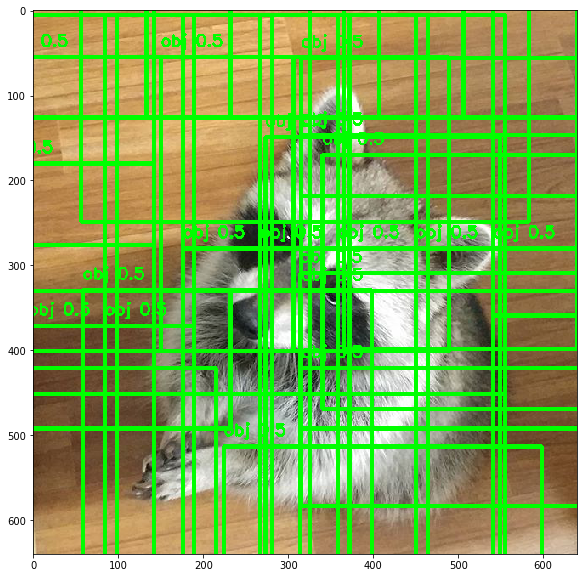

In [174]:
image = cv2.imread('/home/ankish1/ankish_save/yolo/retinaNet/raccoon-data/val-images/raccoon-184.jpg')


dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = loaded_model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=0.3,
                      nms_threshold=0.3,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

loaded weights successfully


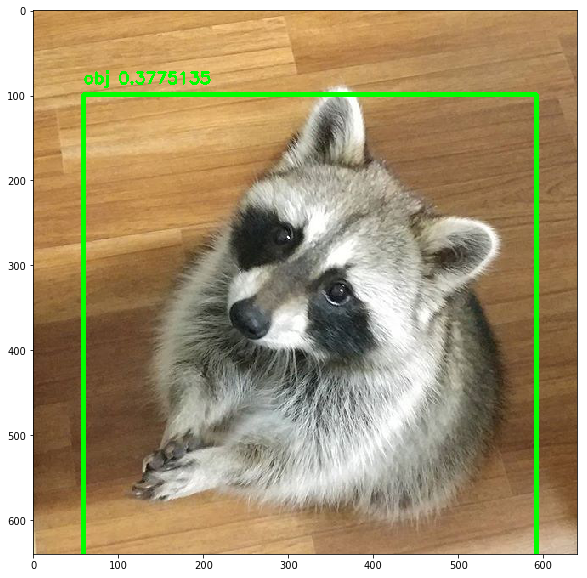

In [175]:
mobilenet_w = np.load('weights/mobilenet.npy')
detection_w = np.load('weights/detectionlayer.npy')
loaded_model.layers[1].set_weights(mobilenet_w)
loaded_model.layers[2].set_weights(detection_w)
print("loaded weights successfully")

image = cv2.imread('/home/ankish1/ankish_save/yolo/retinaNet/raccoon-data/val-images/raccoon-184.jpg')


dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = loaded_model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=0.3,
                      nms_threshold=0.3,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

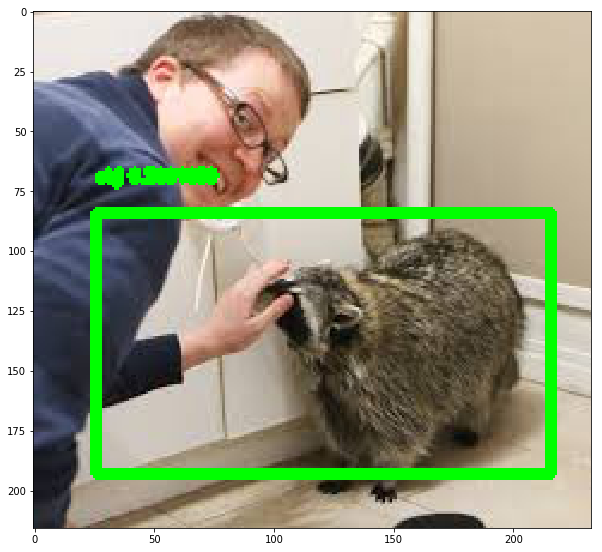

In [177]:
# now
image = cv2.imread('/home/ankish1/ankish_save/yolo/retinaNet/raccoon-data/val-images/raccoon-196.jpg')

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = loaded_model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=0.3,
                      nms_threshold=0.3,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

(576, 768, 3)


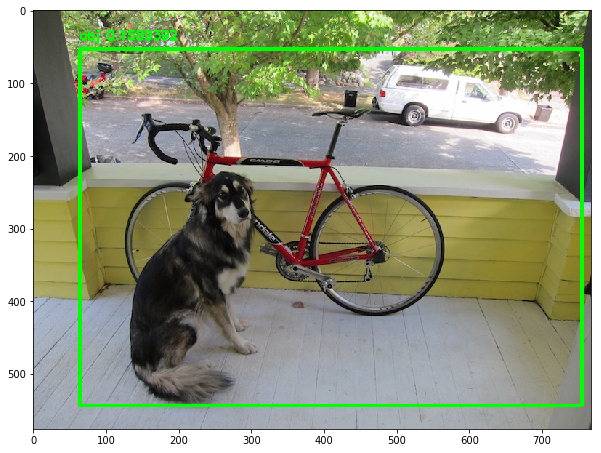

In [186]:
# now
image = cv2.imread('/home/ankish1/ankish_save/yolo/retinaNet/keras-yolo2/experimental/dog.jpg')
print(image.shape)
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = loaded_model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=0.1,
                      nms_threshold=0.3,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

In [190]:
boxes[0].xmin, boxes[0].ymin, boxes[0].xmax, boxes[0].ymax 

(0.08392127877326044,
 0.09370445826325957,
 0.9842318877733303,
 0.94282217089721)

In [37]:
os.listdir('exper/')

['model-flipkart-baseline1-aug-reduce-lr-200-epoch.yaml',
 'model-flipkart-baseline1-aug-reduce-lr-200-epoch.h5']

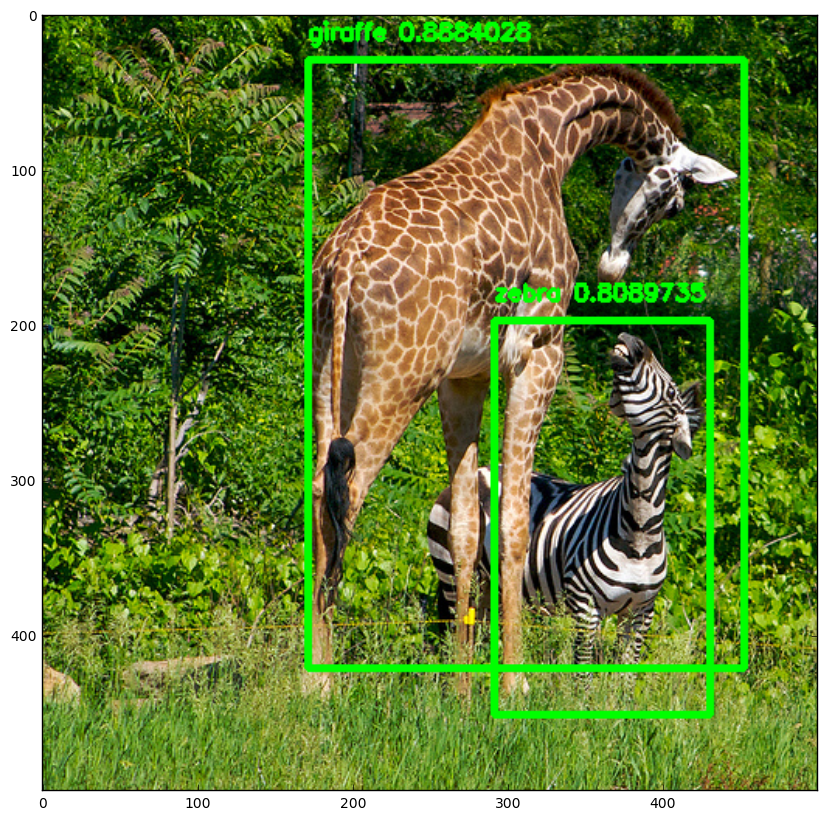

In [8]:
image = cv2.imread('images/giraffe.jpg')
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (416, 416))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

In [ ]:
# # MLP for Pima Indians Dataset serialize to YAML and HDF5
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.models import model_from_yaml
# import numpy
# import os
# # fix random seed for reproducibility
# seed = 7
# numpy.random.seed(seed)
# # load pima indians dataset
# dataset = numpy.loadtxt("pima-indians-diabetes.csv", delimiter=",")
# # split into input (X) and output (Y) variables
# X = dataset[:,0:8]
# Y = dataset[:,8]
# # create model
# model = Sequential()
# model.add(Dense(12, input_dim=8, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
# # Compile model
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# # Fit the model
# model.fit(X, Y, epochs=150, batch_size=10, verbose=0)
# # evaluate the model
# scores = model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# # serialize model to YAML
# model_yaml = model.to_yaml()
# with open("model.yaml", "w") as yaml_file:
#     yaml_file.write(model_yaml)
# # serialize weights to HDF5
# model.save_weights("model.h5")
# print("Saved model to disk")

# # later...

# # load YAML and create model
# yaml_file = open('model.yaml', 'r')
# loaded_model_yaml = yaml_file.read()
# yaml_file.close()
# loaded_model = model_from_yaml(loaded_model_yaml)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

# # evaluate loaded model on test data
# loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# score = loaded_model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))